In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Random Line Sampling Any Points

In [2]:
def f_randomSample(r, c, n):
    totalPoints = len(r)
    idx = np.random.permutation(np.arange(totalPoints))
    idx = idx[:n]
    r2, c2 = [], []
    for i in range(len(idx)):
        r2.append(r[idx[i]])
        c2.append(c[idx[i]])
    return r2, c2

In [3]:
# check the corresponding coordinate of row & column
r = np.arange(10)
c = np.arange(10)[::-1]
r2, c2 = f_randomSample(r, c, 9)
print(r2, c2)

[3, 5, 4, 8, 0, 7, 2, 9, 6] [6, 4, 5, 1, 9, 2, 7, 0, 3]


In [4]:
r

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
c

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [6]:
totalPoints = 10
print(np.random.permutation(np.arange(totalPoints)))

[5 7 9 0 6 3 8 1 2 4]


## RANSAC for Line

### Fitting Line With 2 Points Implementation
Find out the parameters of the line: a and b.

In [7]:
def f_fitline(r1, c1, r2, c2):
    p = np.array([1, 1])
    A = np.array([[r1, 1], [r2, 1]])
    q = np.array([[c1], [c2]])
    if np.linalg.matrix_rank(A) == 2:
        p = np.linalg.inv(A).dot(q)
    a, b = p[0], p[1]
    return a, b

In [8]:
r = np.arange(10)
c = np.arange(10)[::-1]
r2, c2 = f_randomSample(r, c, 2)
a, b = f_fitline(r2[0], c2[0], r2[1], c2[1])

In [9]:
a, b

(array([-1.]), array([9.]))

### Computing Consistency Score

In [10]:
def f_getConsistencyScore(r, c, th, a, b):
    score = 0
    for i in range(len(r)):
        squaredError = (a*r[i]+b - c[i])**2
        if squaredError < th:
            score += 1
    return score

In [57]:
def f_RANSACline(E):
    E = E > 0
    idx = np.argwhere(E)
    r, c = idx[:, 0], idx[:, 1]
    best_a, best_b = 0, 0
    maxScore = -1
    numIter = 15
    for iter in range(numIter):
        r2, c2 = f_randomSample(r, c, 2)
        a, b = f_fitline(r2[0], c2[0], r2[1], c2[1])
        score = f_getConsistencyScore(r, c, 2, a, b)
        if score > maxScore:
            maxScore = score
            best_a, best_b = a, b
    return best_a, best_b

In [58]:
pwd

'/home/thura/Desktop/computer-vision-and-DL/CV-course1/8 - Shape Detection'

In [59]:
E = plt.imread('/home/thura/Desktop/computer-vision-and-DL/CV-course1/8 - Shape Detection/images/E.png')

In [60]:
E.shape

(499, 1153, 4)

In [61]:
E = E[:, :, 0]

In [62]:
E.shape

(499, 1153)

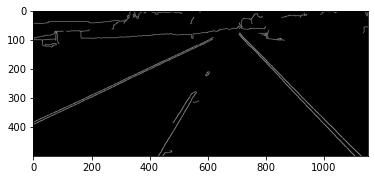

In [63]:
plt.imshow(E, cmap='gray')

In [64]:
E.max(), E.min()

(1.0, 0.0)

In [65]:
E.dtype

dtype('float32')

In [66]:
best_a, best_b = f_RANSACline(E)
best_a, best_b

(array([0.94444444]), array([632.61111111]))

In [67]:
best_a, best_b

(array([0.94444444]), array([632.61111111]))

In [68]:
def f_getExtents(a, b, numRows, numCols):
    r1 = int(0)
    c1 = int(a*r1 + b)
    r2 = int(numRows-1)
    c2 = int(a*r2 + b)
    return (c1, r1), (c2, r2)

In [69]:
s, e = f_getExtents(best_a, best_b, E.shape[0], E.shape[1])

In [70]:
s, e

((632, 0), (1102, 498))

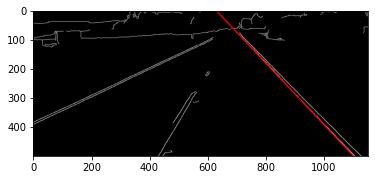

In [71]:
E2 = np.zeros((E.shape[0], E.shape[1], 3), dtype=np.uint8)
E3 = np.array(255*E, dtype=np.uint8)
E2[:, :, 0] = E3
E2[:, :, 1] = E3
E2[:, :, 2] = E3
I = cv2.line(E2, s, e, (0, 0, 255), 3)
plt.imshow(I[:, :, ::-1])

In [72]:
E.dtype

dtype('float32')

In [73]:
E3.dtype

dtype('uint8')

## RANSAC for Circle

### Fitting circle

In [74]:
def f_fitCircle(x1,y1,x2,y2,x3,y3):
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c) 
    px = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
    py = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s 
    ar = a**0.5
    br = b**0.5
    cr = c**0.5 
    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    return px,py,r

In [75]:
def f_getConsistencyScore_circle(r,c,th,cr,cc,d):
    score = 0
    for i in range(len(r)):
        sd = ((r[i]-cr)**2 + (c[i]-cc)**2 - d**2)**2
        if sd < th:
            score += 1
    return score

In [76]:
def f_RANSACCircle(E):
    E = E>0
    idx = np.argwhere(E)
    r , c = idx[:,0] , idx[:,1]
    best_cr , best_cc , best_d = 0 , 0 , 0
    maxScore = -1
    numIter = 2000
    for iter in range(numIter):
        r2,c2 = f_randomSample(r,c,3)
        cr,cc,d = f_fitCircle(r2[0],c2[0],r2[1],c2[1],r2[2],c2[2])
        score = f_getConsistencyScore_circle(r,c,3,cr,cc,d)
        if score > maxScore:
            maxScore = score
            best_cr , best_cc , best_d = cr , cc , d
    return best_cr , best_cc , best_d

In [83]:
E = cv2.imread('/home/thura/Desktop/computer-vision-and-DL/CV-course1/8 - Shape Detection/images/Ec.png',cv2.IMREAD_GRAYSCALE)

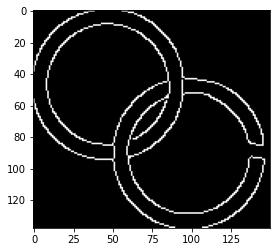

In [84]:
plt.imshow(E, cmap='gray')

In [85]:
E.shape

(138, 150)

In [86]:
E.max(), E.min()

(255, 0)

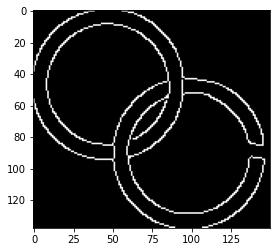

In [87]:
E = E > 100
plt.imshow(E, cmap='gray')

In [88]:
best_cr, best_cc, best_d = f_RANSACCircle(E)

/home/thura/Desktop/computer-vision-and-DL/cv-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
/home/thura/Desktop/computer-vision-and-DL/cv-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/home/thura/Desktop/computer-vision-and-DL/cv-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [89]:
best_cr, best_cc, best_d

(46.5, 47.5, 48.088460154178335)

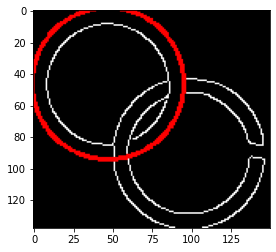

In [90]:
E2 = np.zeros((E.shape[0],E.shape[1],3),dtype=np.uint8)
E3 = np.array(255*E,dtype = np.uint8)
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
I = cv2.circle(E2,(int(best_cc),int(best_cr)),int(best_d),(0,0,255),2)
plt.imshow(I[:,:,::-1])